# MIRACL Dataset
This Notebook demonstrates the setup of the MIRACL dataset for use in _PyTerrier_. The dataset is available on Huggingface and comprises two parts:

1. **[miracl/miracl-corpus](https://huggingface.co/datasets/miracl/miracl-corpus)**: Contains the _corpus_ data.

2. **[miracl/miracl](https://huggingface.co/datasets/miracl/miracl)**: Contains the _topics_ and _qrels_.


In [2]:
# Dependencies
%pip install python-terrier   # PyTerrier
%pip install datasets         # Hugging Face
%pip install tqdm             # tqdm progress bars
%pip install pandas           # pandas

# somehow necessary on Mac, not sure about other OS
%pip install --upgrade jupyter ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Libraries
import pyterrier as pt
import datasets
import pandas as pd
from tqdm import tqdm

In [4]:
# Initialize PyTerrier
if not pt.started():
    pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [5]:
# Load miracl datasets
lang='sw'   # choose language
miracl_corpus = datasets.load_dataset('miracl/miracl-corpus', lang, trust_remote_code=True)  # splits: train
miracl_queries = datasets.load_dataset('miracl/miracl', lang, trust_remote_code=True)        # splits: train, dev, testA, testB

In [30]:
# def limited_miracl_corpus_iter(limit=1000):
#     count = 0
#     for doc in tqdm(miracl_corpus['train'], desc="Processing Corpus"):
#         if count >= limit:
#             break
#         yield {
#             'docno': doc['docid'], 
#             'title': doc['title'],
#             'text': doc['text']
#         }
#         count += 1

# # Preparing queries and qrels for PyTerrier
# queries = []
# qrels = []
# for idx, data in enumerate(tqdm(miracl_queries['dev'], desc="Processing Queries and Qrels")):
#     queries.append({'qid': data['query_id'], 'query': data['query']})
#     for entry in data['positive_passages']:
#         qrels.append({'qid': data['query_id'], 'docno': entry['docid'], 'label': 1})
#     for entry in data['negative_passages']:
#         qrels.append({'qid': data['query_id'], 'docno': entry['docid'], 'label': 0})


In [6]:
# Choose split for queries dataset
split = 'dev'   # 'dev', 'train', 'testA', 'testB'

# Corpus iterator
def miracl_corpus_iter():
    for doc in tqdm(miracl_corpus['train'], desc="Processing Corpus"):
        yield {
            'docno': doc['docid'], 
            'title': doc['title'],
            'text': doc['text']
        }

# Preparing queries and qrels for PyTerrier
queries = []
qrels = []
for idx, data in enumerate(tqdm(miracl_queries[split], desc="Processing Queries and Qrels")):
    # if idx >= 10:  # Limit to first 10 queries
    #     break
    queries.append({'qid': data['query_id'], 'query': data['query']})
    for entry in data['positive_passages']:
        qrels.append({'qid': data['query_id'], 'docno': entry['docid'], 'label': 1})
    for entry in data['negative_passages']:
        qrels.append({'qid': data['query_id'], 'docno': entry['docid'], 'label': 0})


queries_df = pd.DataFrame(queries)
qrels_df = pd.DataFrame(qrels)

Processing Queries and Qrels: 100%|██████████| 482/482 [00:00<00:00, 12085.60it/s]


In [7]:
# Indexing
indexer = pt.IterDictIndexer("./miracl_index", overwrite=True, blocks=True)
index_ref = indexer.index(miracl_corpus_iter())

Processing Corpus:   0%|          | 101/131924 [00:00<08:02, 273.15it/s]

14:01:42.226 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (30#5) - further warnings are suppressed


Processing Corpus: 100%|██████████| 131924/131924 [00:05<00:00, 22828.31it/s]


14:01:49.321 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer - Indexed 129 empty documents


In [33]:
# BM25 Single Query Testing/Debugging
# bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")
# test_query_df = pd.DataFrame([{'qid': 'test', 'query': "Testx"}])
# test_query_df['query'] = test_query_df['query'].str.replace("x", "omato")
# print(test_query_df)
# test_results = bm25.transform(test_query_df)

In [8]:
# BM25
bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")

# Preprocessing
queries_df['query'] = queries_df['query'].str.replace('?', '')  # remove question marks
queries_df['query'] = queries_df['query'].str.replace("'", "")  # remove apostrophes
queries_df['query'] = queries_df['query'].str.replace("/", "")  # remove slash
queries_df['query'] = queries_df['query'].str.replace(":", "")  # remove colon
queries_df['query'] = queries_df['query'].str.replace("!", "")  # remove exclamation mark
# add further replace statements should you encounter any "Lexical Error"
# not sure though if this is the right way to solve it

# Apply BM25 to preprocessed queries
results = bm25.transform(queries_df)

In [9]:
# Evaluation
eval_metrics = ['map', 'ndcg']
eval_results = pt.Experiment(
    [bm25],
    queries_df,
    qrels_df,
    eval_metrics=eval_metrics,
    #perquery=True
)

print(eval_results)

       name       map      ndcg
0  BR(BM25)  0.227746  0.361821


# mDPR Ranking and Evaluation

Besides BM25, we also demonstrate the use of mDPR for ranking and evaluation. mDPR is a dense retrieval model that uses a pre-trained transformer model to encode both the queries and documents into dense vectors. The dense vectors are then used to compute the similarity between the queries and documents. The similarity scores are used to rank the documents for a given query.


In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-cased")

Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# For each query in queries_df, get the top 100 results from BM25 and re-rank them using the mBERT model.
# Afterwards, calculate the evaluation metrics for the re-ranked results.


bm25_results = bm25.transform(queries_df)
bm25_results = bm25_results.groupby('qid').head(100)  # get top 100 results for each query

print(bm25_results)
    


         qid  docid      docno  rank      score  \
0          6  49391    32589#0     0  23.856485   
1          6  77756    67527#0     1  20.334371   
2          6  13415     6117#3     2  19.917020   
3          6   1514     1790#7     3  19.719381   
4          6  13435    6117#23     4  19.554268   
...      ...    ...        ...   ...        ...   
477000  2597  57562    35542#2    95  10.708966   
477001  2597  66749   48278#42    96  10.697793   
477002  2597  66829  48278#122    97  10.697793   
477003  2597  75509    65458#0    98  10.697793   
477004  2597  83052    72315#0    99  10.697793   

                                      query  
0       Bandari kubwa nchini Kenya iko wapi  
1       Bandari kubwa nchini Kenya iko wapi  
2       Bandari kubwa nchini Kenya iko wapi  
3       Bandari kubwa nchini Kenya iko wapi  
4       Bandari kubwa nchini Kenya iko wapi  
...                                     ...  
477000     Paul Schulze alizaliwa mwaka upi  
477001     Paul Sch

In [85]:
# For each docno, get the text from the corpus and encode it using the mBERT tokenizer.
max_seq_length = 512

# Encode documents
docno_encodings = {}
for doc in miracl_corpus_iter():
    encoding = tokenizer(doc['text'], truncation=True, padding='max_length',
                         max_length=max_seq_length, return_tensors='pt')
    docno_encodings[doc['docno']] = encoding

# Encode queries
query_encodings = {}
for idx, row in queries_df.iterrows():
    encoding = tokenizer(row['query'], truncation=True, padding='max_length',
                         max_length=max_seq_length, return_tensors='pt')
    query_encodings[row['qid']] = encoding

# Print the first 10 query encodings and the first 10 docno encodings
print("Query encodings:", len(query_encodings))
print("Doc encodings:", len(docno_encodings))

Processing Corpus: 100%|██████████| 131924/131924 [00:36<00:00, 3653.87it/s]


Query encodings: 482
Doc encodings: 131924


Query encoding lengths: defaultdict(<class 'int'>, {10: 38, 15: 50, 22: 3, 13: 65, 12: 49, 14: 61, 16: 41, 20: 6, 24: 1, 8: 12, 19: 18, 9: 14, 11: 43, 18: 22, 17: 39, 7: 10, 25: 2, 21: 5, 28: 2, 6: 1})
Doc encoding lengths: defaultdict(<class 'int'>, {114: 266, 134: 195, 67: 925, 69: 871, 119: 295, 78: 688, 63: 1212, 102: 393, 55: 1547, 65: 1183, 48: 1288, 26: 1832, 41: 1217, 47: 1242, 46: 1391, 23: 1172, 147: 142, 38: 1314, 75: 773, 117: 272, 161: 120, 142: 171, 89: 527, 37: 1446, 40: 1327, 113: 306, 33: 1691, 51: 1288, 17: 1886, 64: 1161, 86: 536, 68: 903, 58: 1309, 60: 1185, 73: 802, 187: 68, 84: 573, 49: 1332, 12: 1199, 103: 360, 72: 787, 25: 1507, 150: 139, 66: 1060, 61: 1208, 182: 107, 30: 1651, 298: 25, 56: 1599, 91: 521, 14: 817, 115: 276, 16: 1236, 122: 244, 45: 1337, 43: 1254, 35: 1534, 85: 547, 100: 356, 22: 1515, 70: 936, 15: 1083, 74: 753, 123: 236, 54: 1578, 11: 887, 20: 3268, 21: 1729, 39: 1298, 80: 731, 121: 270, 88: 517, 32: 1595, 99: 411, 160: 120, 139: 188, 253: 35, 

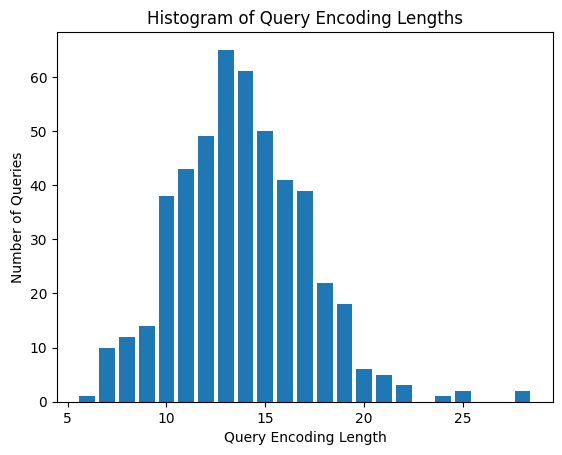

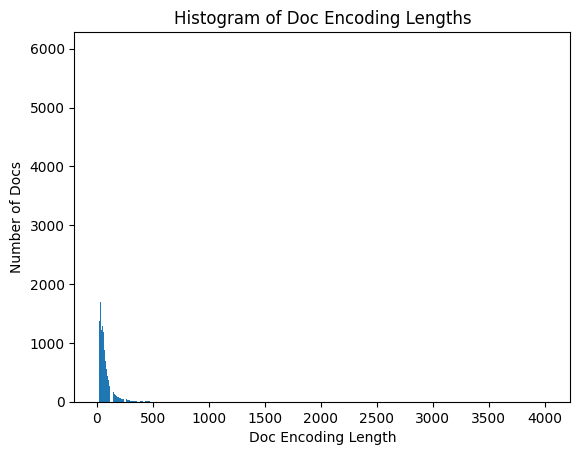

In [46]:
from collections import defaultdict

query_encoding_lengths = defaultdict(int)
doc_encoding_lengths = defaultdict(int)

for key, value in query_encodings.items():
    query_encoding_lengths[value['input_ids'].shape[1]] += 1

for key, value in docno_encodings.items():
    doc_encoding_lengths[value['input_ids'].shape[1]] += 1

print("Query encoding lengths:", query_encoding_lengths)
print("Doc encoding lengths:", doc_encoding_lengths)

import matplotlib.pyplot as plt
# Histogram of query encoding lengths
plt.bar(query_encoding_lengths.keys(), query_encoding_lengths.values())
plt.xlabel('Query Encoding Length')
plt.ylabel('Number of Queries')
plt.title('Histogram of Query Encoding Lengths')
plt.show()

# Histogram of doc encoding lengths
plt.bar(doc_encoding_lengths.keys(), doc_encoding_lengths.values())
plt.xlabel('Doc Encoding Length')
plt.ylabel('Number of Docs')
plt.title('Histogram of Doc Encoding Lengths')
plt.show()

In [15]:
bm25_limit = 100
bm25_results = bm25.transform(queries_df)
bm25_results = bm25_results.groupby('qid').head(bm25_limit)  # get top x results for each query

In [86]:
# For each docno encoding, calculate the similarity to each query encoding
# Store the results in a dictionary with the following structure: {qid: {docno: similarity}}
# The similarity can be calculated using the dot product of the query and docno encodings.
%pip install mlx
import mlx.core as mx
import mlx.nn as nn

rankings_query_doc = {}

for idx, (qid, query_encoding) in enumerate(tqdm(query_encodings.items())):
    rankings_query_doc[qid] = {}
    mx_query_encoding = mx.array(query_encoding['input_ids'])

    # Go through bm25 results for this query
    for idx, row in bm25_results[bm25_results['qid'] == qid].iterrows():
        docno = row['docno']
        doc_encoding = docno_encodings[docno]
        similarity = nn.losses.cosine_similarity_loss(mx_query_encoding, mx.array(doc_encoding['input_ids']))
        rankings_query_doc[qid][docno] = similarity[0] * 100.0

    # Go through all documents
    # for docno, doc_encoding in docno_encodings.items():
    #     similarity = nn.losses.cosine_similarity_loss(mx.array(query_encoding['input_ids']), mx.array(doc_encoding['input_ids']))
    #     rankings_query_doc[qid][docno] = similarity

# For the first query, print the docno similarities
print(rankings_query_doc[queries_df['qid'].iloc[0]])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


100%|██████████| 482/482 [00:02<00:00, 165.36it/s]


{'32589#0': array(11.1445, dtype=float32), '67527#0': array(18.8458, dtype=float32), '6117#3': array(51.2958, dtype=float32), '1790#7': array(16.7776, dtype=float32), '6117#23': array(17.4779, dtype=float32), '9918#1': array(23.7652, dtype=float32), '60160#0': array(23.8367, dtype=float32), '18455#0': array(22.421, dtype=float32), '86671#3': array(23.4286, dtype=float32), '17499#3': array(18.2305, dtype=float32), '26157#2': array(51.6494, dtype=float32), '3680#6': array(77.4792, dtype=float32), '75295#10': array(49.8025, dtype=float32), '3381#0': array(26.4473, dtype=float32), '1675#1': array(49.2731, dtype=float32), '1676#22': array(13.6246, dtype=float32), '33426#8': array(13.6246, dtype=float32), '93957#2': array(30.0458, dtype=float32), '18137#12': array(28.9334, dtype=float32), '32480#0': array(9.29504, dtype=float32), '2800#2': array(34.0305, dtype=float32), '9173#0': array(38.9597, dtype=float32), '16516#1': array(5.87637, dtype=float32), '56081#5': array(24.798, dtype=float32),

In [90]:
# For each query, sort the docno similarities and get the top x docnos
top_x = 100
top_x_docnos = {}

for idx, (qid, docno_similarities) in enumerate(tqdm(rankings_query_doc.items())):
    top_x_docnos[qid] = sorted(docno_similarities, key=docno_similarities.get, reverse=True)[:top_x]

# For the first query, print the top x docnos
print(top_x_docnos[queries_df['qid'].iloc[0]])

100%|██████████| 482/482 [00:39<00:00, 12.17it/s]

['16516#1', '28317#1', '24245#0', '19310#4', '15084#0', '32480#0', '5288#6', '56748#13', '5959#4', '64654#0', '19382#2', '64654#10', '22112#6', '32589#0', '24439#0', '17159#9', '9753#1', '83118#8', '33602#0', '1203#8', '75004#6', '10035#9', '1676#22', '33426#8', '3194#4', '35611#0', '18635#5', '3054#3', '8404#0', '15325#0', '15261#0', '11457#12', '1790#7', '83268#8', '1169#26', '71564#0', '28501#8', '33690#1', '6117#23', '71057#0', '17499#3', '2161#11', '66164#4', '67527#0', '87006#1', '2839#1', '1677#0', '98686#9', '69559#0', '82492#0', '16309#2', '78993#6', '18455#0', '2737#10', '55792#0', '86671#3', '9918#1', '60160#0', '6095#4', '9509#1', '28502#0', '15656#0', '56081#5', '3945#0', '2737#6', '82492#2', '3381#0', '84779#0', '103478#0', '8319#0', '2109#58', '18137#12', '2381#1', '18693#0', '93957#2', '101453#1', '103480#0', '5288#10', '3401#7', '2800#2', '32480#3', '8408#1', '5288#1', '103477#0', '24245#1', '72202#7', '3146#0', '28508#0', '9173#0', '16#3', '39692#0', '14146#6', '3507#

In [91]:
# Create pandas dataframe with the top x docnos for each query
# The dataframe should have the following columns: qid, docno, score, rank
import pandas as pd

data = []
for qid, docnos in top_x_docnos.items():
    for rank, docno in enumerate(docnos):
        score = rankings_query_doc[qid][docno].item()
        data.append({'qid': qid, 'docno': docno, 'score': score, 'rank': rank})

rankings_df = pd.DataFrame(data)
print(rankings_df)


        qid     docno      score  rank
0         6   16516#1   5.876369     0
1         6   28317#1   7.276518     1
2         6   24245#0   7.811049     2
3         6   19310#4   8.073642     3
4         6   15084#0   8.503650     4
...     ...       ...        ...   ...
48173  2597  34555#39  61.671658    95
48174  2597   16778#3  62.030506    96
48175  2597   14107#1  66.248665    97
48176  2597   2944#47  75.475204    98
48177  2597   91404#1  77.806778    99

[48178 rows x 4 columns]


In [96]:
# Evaluation
eval_metrics = ['map', 'ndcg']
eval_results = pt.Experiment(
    [rankings_df],
    queries_df,
    qrels_df,
    eval_metrics=eval_metrics,
    # perquery=True
)

print(eval_results)

                                                name       map      ndcg
0          qid     docno      score  rank\n0     ...  0.018677  0.131025


In [75]:
# Evaluation
eval_metrics = ['map', 'ndcg']
eval_results = pt.Experiment(
    [bm25_results],
    queries_df,
    qrels_df,
    eval_metrics=eval_metrics,
    # perquery=True
)

print(eval_results)

                                                name       map      ndcg
0           qid  docid      docno  rank      scor...  0.226438  0.333694
